In [12]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

from scipy.stats import multivariate_normal
import numpy as np

# Others
import os
import shutil
import zipfile
import random
import time 

from rasterio.plot import show

%matplotlib inline

In [2]:
pre_event_image = './Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

In [13]:
def sampleTiles(width, height, num_tiles =100):
    
    photo_width = width
    photo_height = height

    mean_offset_x = width // 2  # Horizontal center
    mean_offset_y = height // 2  # Vertical center
    std_deviation_x = 5000  # Variation in x-dimension
    std_deviation_y = 10000  # Variation in y-dimension
    
    sampled = {}
    
    for i in range(num_tiles): 
        x_offset = int(np.random.normal(mean_offset_x, std_deviation_x))
        y_offset = int(np.random.normal(mean_offset_y, std_deviation_y))
        sampled[i] = (x_offset,y_offset)
    
    return sampled


def generate_tiles(input_file, output_dir, grid_x, grid_y, num_tiles):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Sample tiles
    sampled_tiles = sampleTiles(width, height, num_tiles)
    
    
    # Iterate over each sampled tile and save as a separate TIFF image
    for tile_number, (sampled_x, sampled_y) in sampled_tiles.items():
        # Calculate tile boundaries based on sampled pixel coordinates
        x_offset = max(0, sampled_x - grid_x // 2)
        y_offset = max(0, sampled_y - grid_y // 2)
        
        tile_width = min(grid_x, width - x_offset)
        tile_height = min(grid_y, height - y_offset)

        # Read data for the tile
        tile = []
        for band in range(1, num_bands + 1):
            tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
            tile.append(tile_data)

        # Create output filename
        output_file = os.path.join(output_dir, f"tile_{tile_number}.tif")
            
        # Create an output TIFF file with same CRS and band values range
        driver = gdal.GetDriverByName("GTiff")
        options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
        out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                   ds.GetRasterBand(1).DataType, options=options)

        # Set the geotransform
        geotransform = list(ds.GetGeoTransform())
        geotransform[0] = geotransform[0] + x_offset * geotransform[1]
        geotransform[3] = geotransform[3] + y_offset * geotransform[5]
        out_ds.SetGeoTransform(tuple(geotransform))

        # Set the projection
        out_ds.SetProjection(ds.GetProjection())

        # Write each band to the output file
        for band in range(1, num_bands + 1):
            out_band = out_ds.GetRasterBand(band)
            out_band.WriteArray(tile[band - 1])

        # Close the output file
        out_ds = None

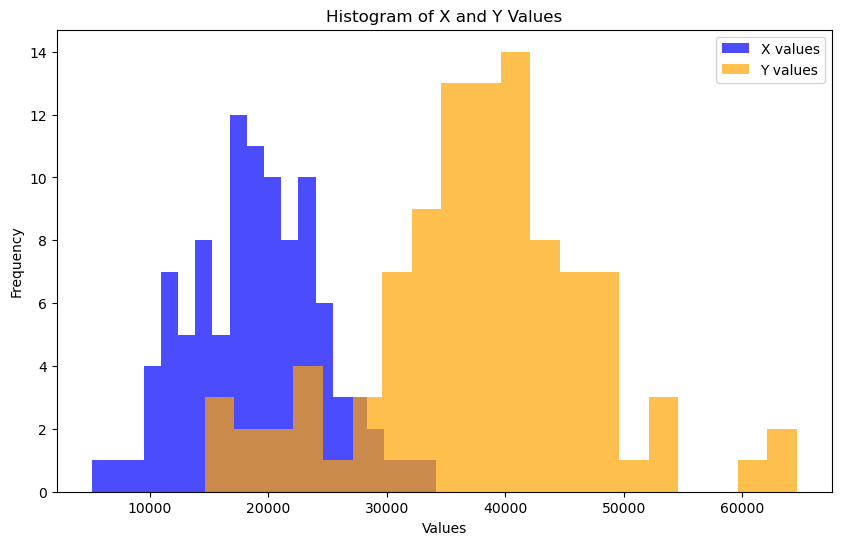

In [14]:
ds = gdal.Open("./Post_Event_San_Juan.tif")

# Get image size and number of bands
width = ds.RasterXSize
height = ds.RasterYSize
num_bands = ds.RasterCount


data = sampleTiles(width=width, height=height)

# Extract the first and second values from the tuples
x_values = [item[0] for item in data.values()]
y_values = [item[1] for item in data.values()]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(x_values, bins=20, alpha=0.7, color='blue', label='X values')
plt.hist(y_values, bins=20, alpha=0.7, color='orange', label='Y values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of X and Y Values')
plt.legend()
plt.show()

In [15]:
# Generating Tiles for Post Event
input_file = "./Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF_SecondBatch"

grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y,num_tiles=100)

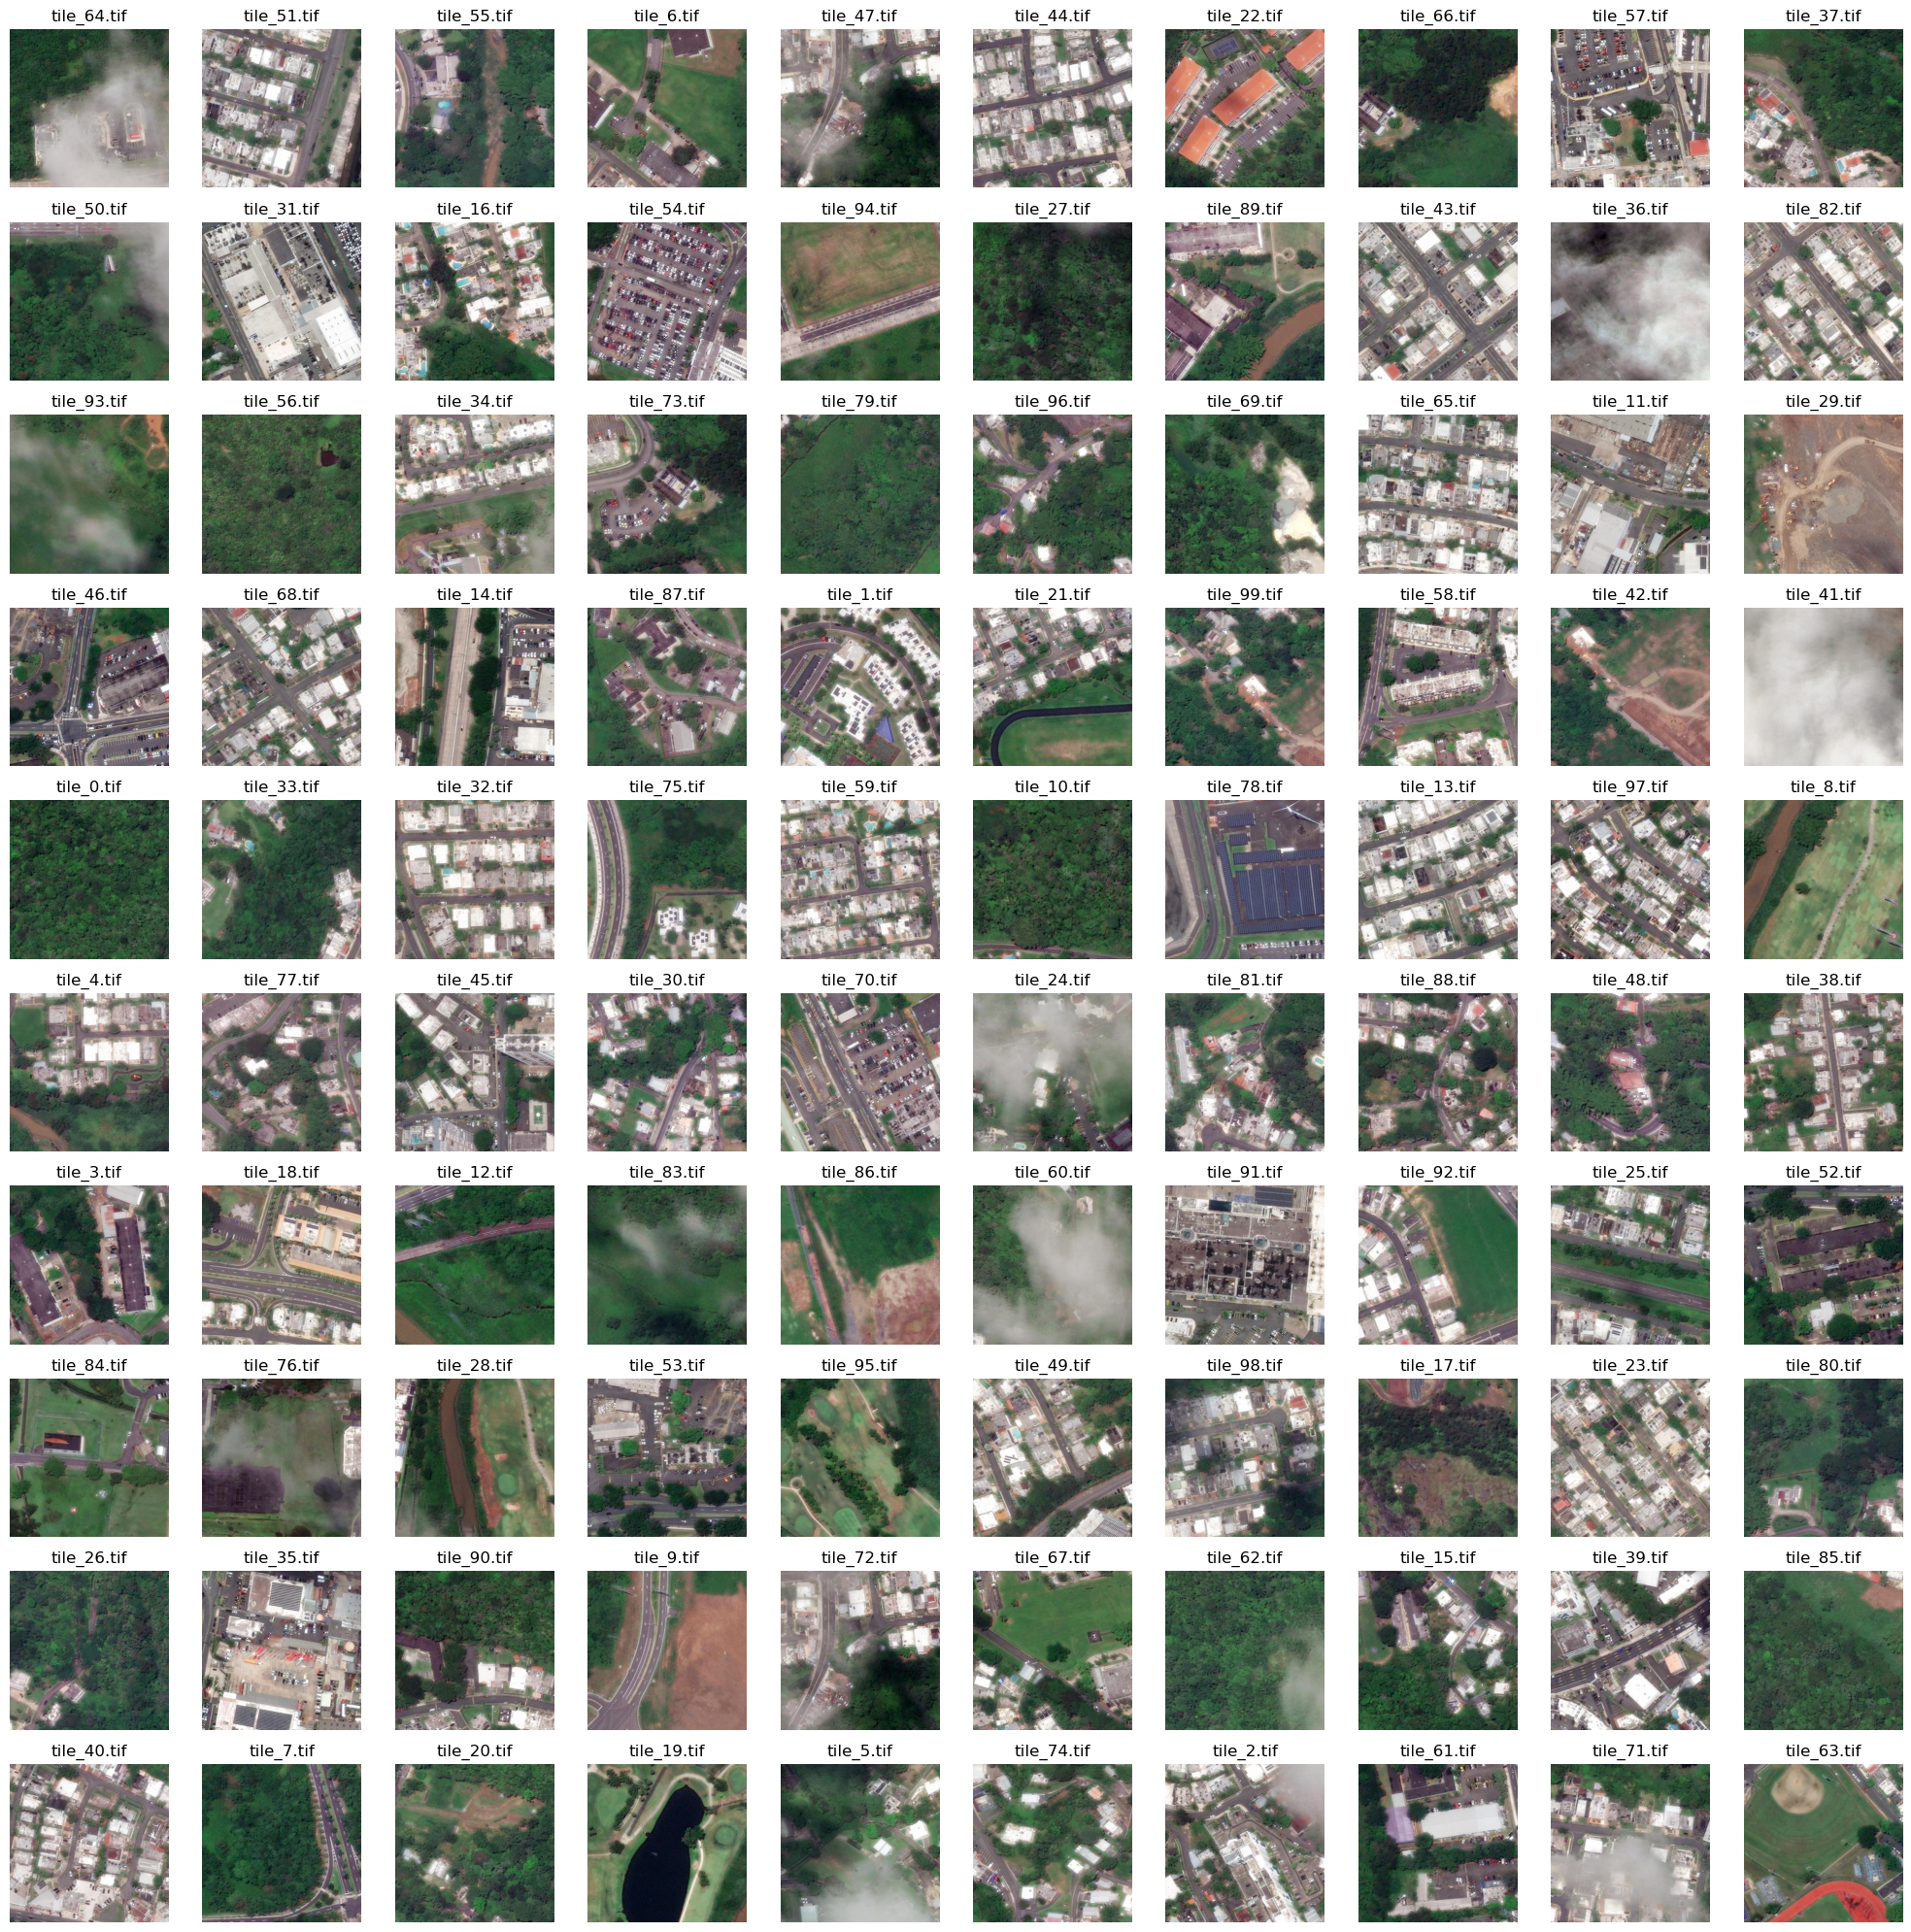

In [17]:
contents = os.listdir(output_dir)

fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i, item in enumerate(contents):
    if item.endswith(".tif") and i < 100:
        row = i // 10
        col = i % 10
        img = rasterio.open(os.path.join(output_dir, item))
        image_data = img.read()  # Read all bands
        # Select the first three bands assuming they represent RGB
        rgb_image = image_data[:3, :, :]
        axs[row, col].imshow(rgb_image.transpose([1, 2, 0]))
        axs[row, col].axis('off')
        axs[row, col].set_title(item)

plt.tight_layout()
plt.show()

In [18]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [19]:
# specify directory
input_dir = "./Pre_Event_Grids_In_TIFF_SecondBatch"
output_dir = "./Pre_Event_Grids_In_JPEG_SecondBatch"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.
